In [1]:
import numpy as np
import pandas as pd
import math
import SALib
from SALib.sample import latin
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Define fontsizes
lab_font_size = 20
tick_font_size = 20
anno_font_size = 16
fig_path = '../../output/paper3/'

In [3]:
# Define the function
# Parameters x are defined on [-1, 1]
def diff_power(x1, x2):
    """
    Parameters:
    x1, x2: np.ndarray, matrix of parameter values for the Gaussian peak integrand family (GPI).
    
    Return:
    y: np.ndarray, the output of SDP function.
    """
    y = math.exp(-25 * (x1 - 0.5)**2 - 4*(x2 - 0.5) ** 2 - 5*(x1-0.5)*(x2-0.5))
    return y
# vetorize diff_power fucntion 
v_func = np.vectorize(diff_power)

## Create the contour plot

In [5]:
# Create meshgrid points
x = np.array(np.meshgrid(np.linspace(0, 1, 1000),
                   np.linspace(0, 1, 1000)))

# Fix parameters at certain points and calculate the related  results
# Fix x2 
fix_1 = 0.5
fix_2 = 0.7
y_thres = 0.8
# Calculate the unconditioned results
z = v_func(x[0], x[1])

In [6]:
fig = go.Figure(data =
    go.Contour(
        z = z,
        x = x[0][0],
        y = x[1][:,0],
        colorbar = dict(title='Values', # title here
            titleside='top',
            titlefont=dict(
            size=lab_font_size),
            tickfont = dict(size = tick_font_size)
            ),
        colorscale='sunset',
    contours=dict(
            coloring ='heatmap',
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 12,
                color = 'white'),
            start=0,
            end=1,
            size=0.1),
            ))


fig.update_traces(line_color='black', selector=dict(type='contour'))
fig.add_trace(go.Scatter(x=[0.001, 0.001, 0.999, 0.999, 0.001], y=[0, 1, 1, 0, 0], 
                         fill=None, line_color='royalblue',
                        line_width=2, mode='lines', showlegend=False))

# Highlight the contour line of 0.8 
fig.add_trace(go.Contour(
        z = z,
        x = x[0][0],
        y = x[1][:,0],
    showscale=False,
    colorscale=[[0, 'red'], [1, 'green']],
    contours=dict(
            coloring ='lines',
            showlabels = False, # show labels on contours
            start=0.8,
            end=0.8,
            size=0.1),
            ))
# Add markers indicating optima
fig.add_trace(go.Scatter(x=[0.5, 0.48], y=[fix_1, fix_2], \
                         mode='markers', marker={'symbol':2,'size':8, 'color':['red', 'green']}, showlegend=False))

# Add annotations to contour plot
fig.add_hline(y=fix_1, line_width=1.5, line_dash="dash", line_color="red", 
              annotation_text = r'$f(x_1, x_2=%.1f)$'%fix_1, annotation_font_size = anno_font_size)
fig.add_hline(y=fix_2, line_width=1.5, line_dash="dash", line_color="green", 
              annotation_text = r'$f(x_1, x_2=%.1f)$'%fix_2, annotation_font_size = anno_font_size)
fig.update_xaxes(title_text = r'$x_1$', title_font = {"size": lab_font_size}, tickfont=dict(size=tick_font_size))
fig.update_yaxes(title_text = r'$x_2$',title_font = {"size": lab_font_size},  tickfont=dict(size=tick_font_size))
fig.update_layout(font_family='arial')
fig.write_image(f'{fig_path}contour_1114.png')

## Create boxplot

In [7]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
# random sampling to over parameter space and then fix variable x2
problem = {'num_vars': 2,
          'names': ['x1', 'x2'],
          'bounds': [[0, 1], 
                    [0, 1]]
          }
sample_size = 1000
param_values_full = latin.sample(problem, sample_size)
x1_full = param_values_full[:, 0]
x2_full = param_values_full[:, 1]
z_uncon = v_func(x1_full, x2_full)

# Calculate the conditional values with x2 fixed.
group_labels = [r'$f(x_1, x_2)$', r'$f(x_1, x_2=%.1f)$'%(fix_1), r'$f(x_1, x_2=%.1f)$'%(fix_2)]
z_c1 = v_func(x1_full, fix_1)
z_c2 = v_func(x1_full, fix_2)

In [8]:
# Form data into a dataframe before using seaborn
hist_data = [z_uncon, z_c1, z_c2]
df_plot = pd.DataFrame(columns=['x', 'H values', 'Type'], index = np.arange(sample_size * 6))
for xx, yy, indd in zip(group_labels, hist_data, [999, 1999, 2999]):
    df_plot.loc[(indd-999):indd, 'x'] = xx
    df_plot.loc[(indd-999):indd, 'H values'] = yy
df_plot.loc[:, 'Type'] = 'All'

# Add data satisfying the threshold: H>=0.8
ind_start = 3000
for xx, yy in zip(group_labels, hist_data):
    ind =  np.where(yy >= y_thres)[0]
    df_plot.loc[ind_start: (ind_start + ind.shape[0]-1 ), 'x'] = xx
    df_plot.loc[ind_start: (ind_start + ind.shape[0]-1), 'H values'] = yy[ind]
    df_plot.loc[ind_start: (ind_start + ind.shape[0]-1), 'Type'] = 'H>=0.8'
    ind_start  = ind_start + ind.shape[0]    

In [9]:
hist_data = [z_uncon, z_c1, z_c2]
q_1 = np.quantile(hist_data, 0.25, axis=1)
q_3 = np.quantile(hist_data, 0.75, axis=1)
q_m = np.quantile(hist_data, 0.50, axis=1)
lower_bounds = np.quantile(hist_data, 0.025, axis=1)
upper_bounds = np.quantile(hist_data, 0.975, axis=1)

# Dataframe of selected data
z_uncon_fil = z_uncon[np.where(z_uncon >= y_thres)[0]]
z_c1_fil = z_c1[np.where(z_c1 >= y_thres)[0]]
z_c2_fil = z_c2[np.where(z_c2 >= y_thres)[0]]

x1_fil = x1_full[np.where(z_uncon >= y_thres)[0]]
x1_c1 = x1_full[np.where(z_c1 >= y_thres)[0]]
x1_c2 = x1_full[np.where(z_c2 >= y_thres)[0]]

# Quantiles for selected data points
hist_data_fil = np.array([z_uncon_fil, z_c1_fil, z_c2_fil])
q_1_fil = [np.quantile(hist_data_fil[ii], 0.25) for ii in range(3)]
q_3_fil = [np.quantile(hist_data_fil[ii], 0.75) for ii in range(3)]
q_m_fil = [np.quantile(hist_data_fil[ii], 0.50) for ii in range(3)]
lower_bounds_fil = [np.quantile(hist_data_fil[ii], 0.0035) for ii in range(3)]
upper_bounds_fil = [np.quantile(hist_data_fil[ii], 0.9965) for ii in range(3)]

C:\Users\wq\.conda\envs\oed\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [10]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['mathtext.fontset'] = 'stix'

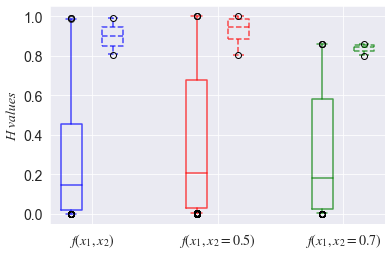

In [11]:
colors=['blue', 'red', 'green']
sns.set_style('darkgrid')
x1_box = np.arange(1,8,3)
x2_box = x1_box+1
fig3 = plt.figure(figsize=(6, 4), edgecolor='grey')
bplt1 = plt.boxplot(hist_data, positions=x1_box, 
           vert=True,  # vertical box alignment
           whis = (3.5, 99.65), 
           patch_artist=False,  # fill with colors
           );
bplt2 = plt.boxplot(hist_data_fil, positions = x2_box,
           vert=True,  # vertical box alignment
           whis = (0.35, 99.65), 
           patch_artist=False,  # fill with colors
           );

plt.ylabel('H values', {'family':'Times New Roman', 'style': 'italic'}, fontsize=14);
plt.xticks([1.5,  4.5,  7.5], group_labels, fontsize=14);
plt.yticks(fontsize=14);

# set box colors for bplt1
for components in list(bplt1.keys())[:-1]:
    ii = 0
    if components in ['whiskers', 'caps']:
        for line in bplt1[components]:
            line.set_color(colors[ii//2])
            line.set_alpha(0.7)
            line.set_linewidth(1.5)
            ii += 1
    else:
        for line in bplt1[components]:
            line.set_color(colors[ii])
            line.set_alpha(0.7)
            line.set_linewidth(1.5)
            ii += 1
# set box colors for bplt2
for components in list(bplt2.keys())[:-1]:
    ii = 0
    if components in ['whiskers', 'caps']:
        for line in bplt2[components]:
            line.set_color(colors[ii//2])
            line.set_alpha(0.7)
            line.set_linestyle('--')
            line.set_linewidth(1.5)
            ii += 1
    elif components in ['boxes', 'medians']:
        for line in bplt2[components]:
            line.set_color(colors[ii])
            line.set_alpha(0.7)
            line.set_linestyle('--')
            line.set_linewidth(1.5)
            ii += 1
    else:
        for marker in bplt2[components]:
            line.set_alpha(0.7)
            marker.set_color(colors[ii])
            line.set_linewidth(1.5)
            ii += 1
plt.savefig(f'{fig_path}boxplot2.png', format = 'png', dpi=300)

## Create scatter plot

In [15]:
# Scatter plot of x2 fixed at fix_1
from plotly.graph_objs import *
fig5 = go.Figure()
k = 0
for ydata, lab in zip(hist_data, group_labels):
    if k != 1:  
        fig5.add_trace(go.Scatter(x = x1_full, y = ydata, mode='markers', name=lab, 
                                  marker = {'size': 6, 'opacity' : 0.7}))
    else:
        fig5.add_trace(go.Scatter(x = x1_full, y = ydata, mode='markers', name=lab, 
                                  marker = {'size': 6, 'opacity' : 0.2}))
    k += 1
fig5.update_yaxes(title_text = r'$H\ values$', title_font = {"size": lab_font_size}, tickfont = {"size" : tick_font_size})
fig5.update_xaxes(title_text = r'$x_1$', title_font = {"size": lab_font_size}, tickfont = {"size" : tick_font_size})
fig5.update_layout(legend=dict(yanchor = "top",
                              y = 0.95,
                              xanchor = "left",
                              x = 0.65, 
                              font = {"size":14}),
                  template='seaborn',
                  font_family='arial')
# fig5.add_vline(x=0.5, line_width=1.5, line_dash="dash", line_color="red", 
#               annotation_text = '')
# fig5.add_vline(x=0.475, line_width=1.5, line_dash="dash", line_color="green", 
#               annotation_text = '')
fig5.write_image(f'{fig_path}scatters-full.png', format = 'png', scale=2)

In [16]:
# Scatter plot of x2 fixed at fix_1
x1_data = [x1_fil, x1_c1, x1_c2]
fig6 = go.Figure()
k = 0
for xx1, ydata, lab in zip(x1_data, hist_data_fil, group_labels):
    if k != 1:  
        fig6.add_trace(go.Scatter(x = xx1, y = ydata, mode='markers', name=lab, 
                                  marker = {'size': 6, 'opacity' : 0.7}))
    else:
        fig6.add_trace(go.Scatter(x = xx1, y = ydata, mode='markers', name=lab, 
                                  marker = {'size': 6, 'opacity' : 0.2}))
    k += 1
fig6.update_yaxes(title_text = r'$H\ values$', title_font = {"size": lab_font_size}, tickfont = {"size" : tick_font_size})
fig6.update_xaxes(title_text = r'$x_1$', title_font = {"size": lab_font_size}, tickfont = {"size" : tick_font_size})
fig6.update_layout(legend=dict(yanchor = "top",
                              y = 0.95,
                              xanchor = "left",
                              x = 0.75, 
                              font = {"size":14}),
                  template='seaborn',
                  font_family='arial')
# fig6.update_layout(showlegend=True)

# fig6.add_vline(x=0.5, line_width=1.5, line_dash="dash", line_color="red", 
#               annotation_text = '')
# fig6.add_vline(x=0.475, line_width=1.5, line_dash="dash", line_color="green", 
#               annotation_text = '')
fig6.write_image(f'{fig_path}scatters-select.png', format = 'png', scale=2)